# Введение в искусственные нейронные сети
# Урок 6. Сегментация

## Задание 1
1.	Попробуйте обучить нейронную сеть U-Net на любом другом датасете. 
Опишите в комментарии к уроку - какой результата вы добились от нейросети? Что помогло вам улучшить ее точность?

## Решение

В качестве практики попробуем сегментировать изображение домашних животных из датасета Oxford-IIIT Pet Dataset, с использованием модифицированной версии U-Net.

In [4]:
# установим модуль для python под названием tensorflow-datasets.
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-k6gpy3ha
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-k6gpy3ha
  Created wheel for tensorflow-examples: filename=tensorflow_examples-f8ea518e0efdbf5d7c75b314133b29e8e0212e70_-cp37-none-any.whl size=265889 sha256=a3f18e0c831d4887f1e2c4cb73f991b1e46859b8d966a0d2f65cfd8c61269da8
  Stored in directory: /tmp/pip-ephem-wheel-cache-8j0_wwla/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [1]:
try:
  %tensorflow_version only exists in Colab.
  #%tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

Unknown TensorFlow version: only exists in Colab.
Currently selected TF version: 2.x
Available versions:
 * 1.x
 * 2.x


In [96]:
import tensorflow.compat.v2 as tf

In [97]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt


import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

### Загрузка датасета Oxford-IIIT Pets

Датасет является стандартным датасетом для TensorFlow, однако как упомяналось выше возможно необходимо будет установить модуль tensorflow-datasets для python.

In [134]:
ds_names = ( 'oxford_iiit_pet:3.*.*',)
dataset_all, info = tfds.load(ds_names[0], 
                              split = ['train[:20%]','test[-20%:]'],
                              shuffle_files=True, 
                              with_info=True)

In [135]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

Следующий код выполнит простую аугументацию данных посредством переворота изображений. В дополнение изображение будет нормализовано к 0 и 1. Пиксели сегментационной маски будут помечены {1, 2, 3}, но для удобства из данного цифрового ряда будет вычтено по 1 и в итоге получиться {0, 1, 2}

In [136]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [137]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [138]:
@tf.function
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

Датасет уже содержит необходимые тестовый и тренировочный сплиты, поэтому давайте использовать их.

In [139]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 16
BUFFER_SIZE = 128
STEPS_PER_EPOCH = TRAIN_LENGTH // 10 // BATCH_SIZE

In [140]:
train = dataset_all[0].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset_all[1].map(load_image_test)

In [141]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

Давайте посмотрим на пример  изображения из датасета и соответствующую ему маску из датасета.

In [142]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

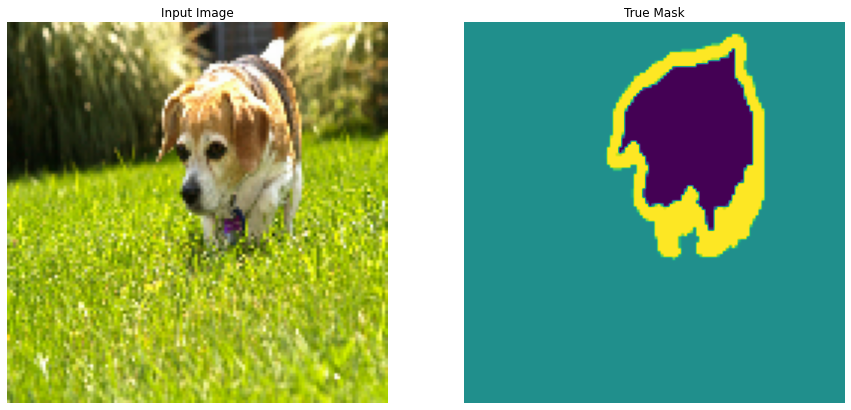

In [143]:
for image, mask in test_dataset.take(6):
  sample_image, sample_mask = image, mask
display([sample_image[0,:,:,:], sample_mask[0,:,:,:]])

In [144]:
sample_mask.numpy().min(),sample_mask.numpy().max()

(0.0, 2.0)

In [145]:
sample_mask.dtype

tf.float32

### Определение модели

Будем использовать модифицированный U-Net. В качестве энкодера будет использоваться предтренированный MobileNetV2.
Декодером будет апсемпл блок уже имплементированный в TensorFlow examples [Pix2pix tutorial](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py).

Причина по который будет использоваться три канала заключается в том что у нас 3 возможных лейбла на каждый пиксель. Можно это воспринимать как классиификацию где каждый пиксель будет принадлежать одному из трех классов.

In [146]:
OUTPUT_CHANNELS = 3

Как упоминалось ранее энкодером будет предтренированный MobileNetV2, который подготовлен и готов к использованию - [tf.keras.applications](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications). Энкодер состоит из определенных аутпутов из средних слоев модели. Обратите внимание энкодр не будет участвовать в процессе тренировкие модели.

In [147]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False



Декодер/апсемплер это просто серия апсемпл блоков имплементированнхы в TensorFlow examples.

In [148]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [149]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

### Тренировка модели с метрикой dice_coef
Теперь, все что осталось это скомпилировать модель и начать процесс ее тренировки. Loss-функция, которую будем использовать - `losses.SparseCategoricalCrossentropy(from_logits=True)`. Причина использования данной loss-функции заключается в том, что нейросеть пытается назначить каждому пикселю лейбл, также как в задачах предсказания класса. Для модели в которой 3 канала каждый из которых пытается предсказать класс `losses.SparseCategoricalCrossentropy(from_logits=True)` обычно также рекомендуется.

На выходе нейросети каждому пикселю назначается лейбл с наибольшим значением. Это то, что делает функция create_mask.


In [150]:
from tensorflow.keras import backend as K
# Это наша метрика на Tensorflow

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [151]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[dice_coef])

Посмотрим на получившуюся архитектуру модели.

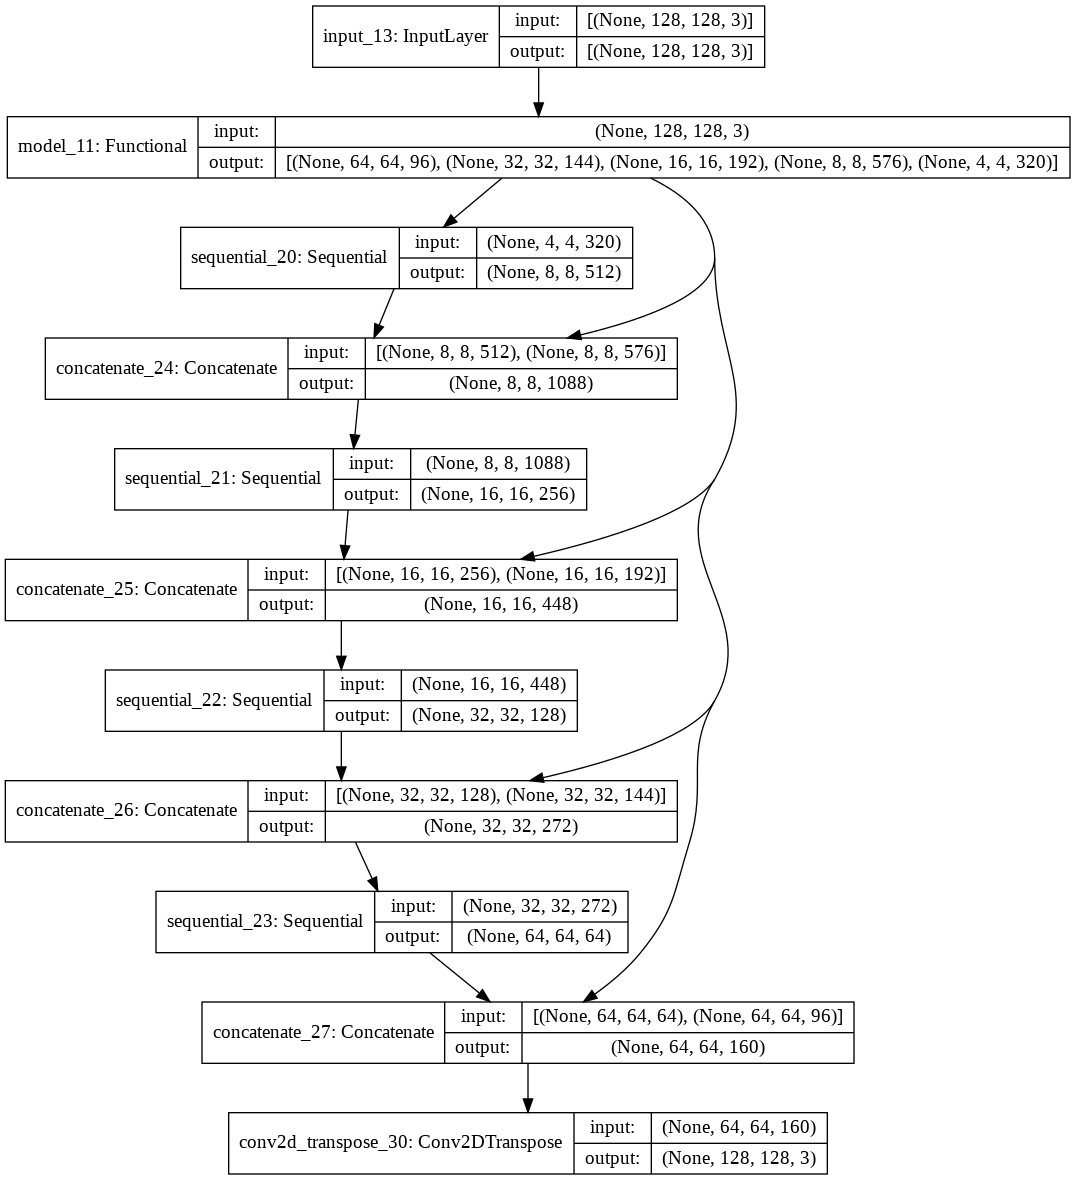

In [152]:
tf.keras.utils.plot_model(model, show_shapes=True)



Определяем callback функцию для  мониторинга того как улучшается работа модели в процессе обучения.

In [153]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

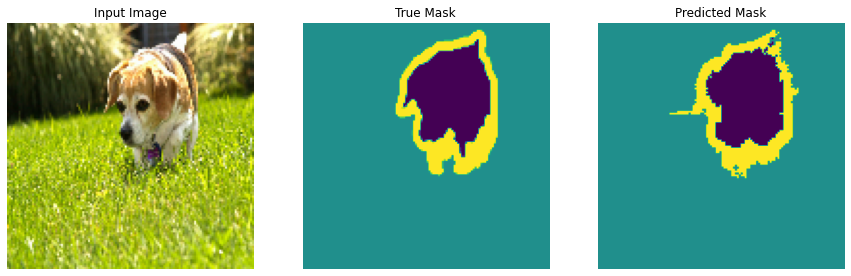


Sample Prediction after epoch 20



In [154]:
EPOCHS = 20 # увеличьте при необходимости
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//10//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

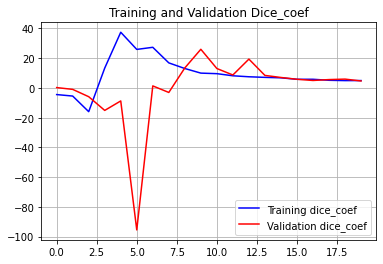

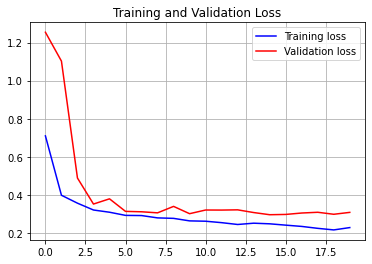

In [157]:
metr = model_history.history['dice_coef']
metr_v = model_history.history['val_dice_coef']
loss = model_history.history['loss']
loss_v = model_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, metr, 'b', label='Training dice_coef')
plt.plot(epochs, metr_v, 'r', label='Validation dice_coef')
plt.grid('on')
plt.legend()
plt.title('Training and Validation Dice_coef')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, loss_v, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.grid('on')
plt.legend()

plt.show()

#### Make predictions

Давайте сделаем несколько предсказаний.

1


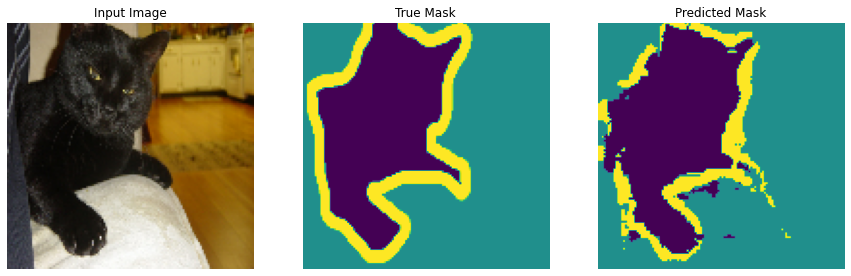

1


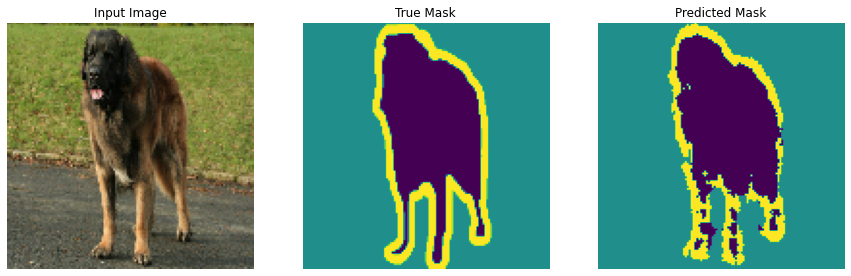

1


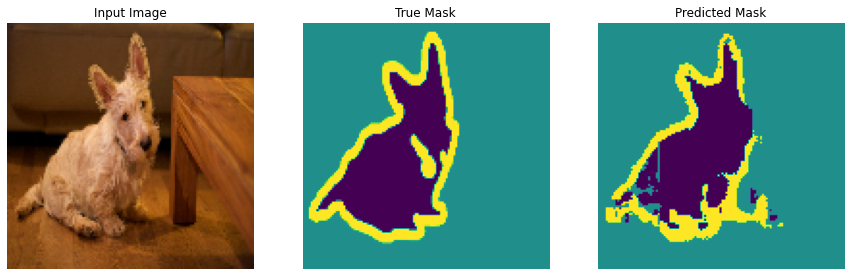

In [156]:
show_predictions(test_dataset, 3)

### Тренировка модели с метрикой accuracy

In [158]:
model_acc = unet_model(OUTPUT_CHANNELS)
model_acc.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

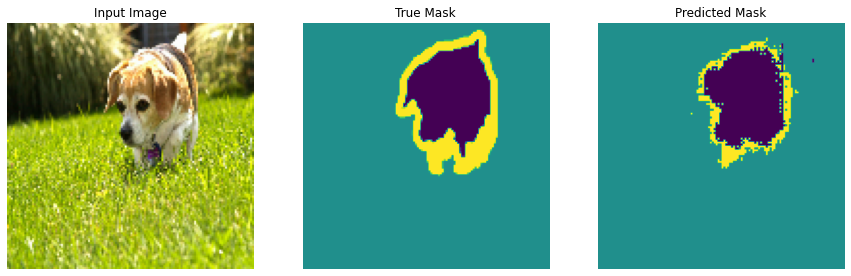


Sample Prediction after epoch 20



In [159]:
EPOCHS = 20 # увеличьте при необходимости
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//10//BATCH_SIZE//VAL_SUBSPLITS

model_history = model_acc.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

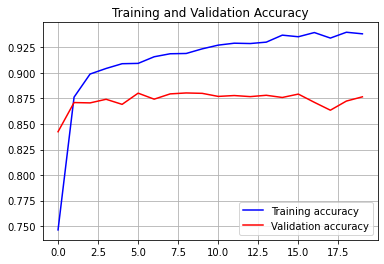

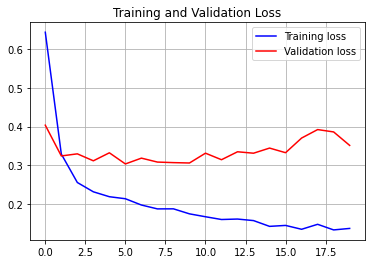

In [160]:
acc = model_history.history['accuracy']
acc_v = model_history.history['val_accuracy']
loss = model_history.history['loss']
loss_v = model_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, acc_v, 'r', label='Validation accuracy')
plt.grid('on')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, loss_v, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.grid('on')
plt.legend()

plt.show()

#### Make predictions

1


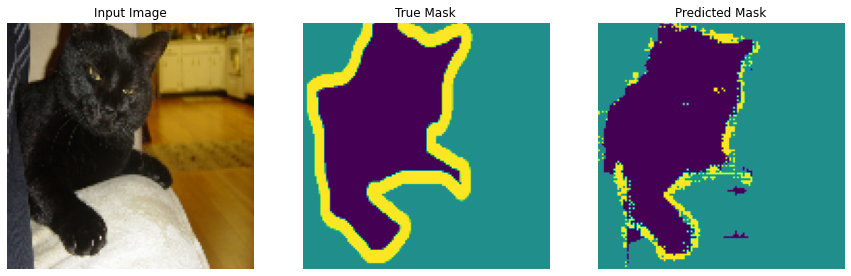

1


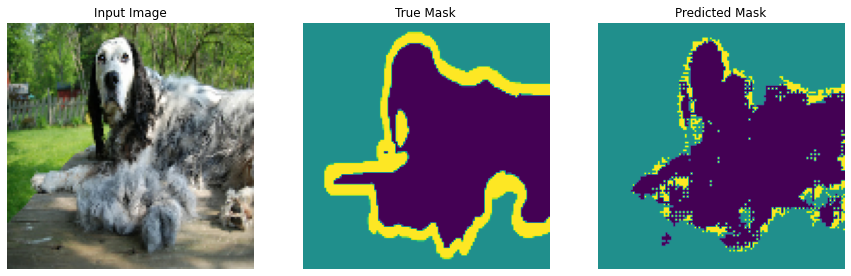

1


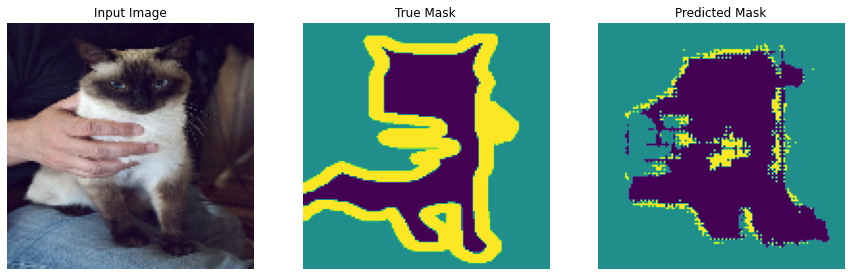

In [161]:
show_predictions(test_dataset, 3)

### Вывод

На данном датасте применение в модели U-Net метрики Деци дает точность выше, чем в случае accuracy.